<a href="https://colab.research.google.com/github/Saha555339/Bitcoin_Time_Series/blob/main/TimeSeries_Article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Прогнозирование цены биткоина

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#Предобработка данных

In [ ]:
df = pd.read_csv("/content/Bitcoin_kaggle.csv", parse_dates=True, index_col='Date', sep=';',
                 decimal='.')
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%


## Парсинг данных

In [ ]:
def convert_vol(num_str):
  multipliers = {'K': 1000, 'M': 1000000}
  suffix = num_str[-1]
  multiplier = multipliers.get(suffix.upper(), 1)
  number = float(num_str[:-1])
  return float(number * multiplier)

In [ ]:
def parse_data(path: str):
  df = pd.read_csv(path, parse_dates=True, index_col='Date', sep=';',
                 decimal='.')

  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Open'] = df['Open'].str.replace(',', '').astype(float)
  df['High'] = df['High'].str.replace(',', '').astype(float)
  df['Low'] = df['Low'].str.replace(',', '').astype(float)
  df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100

  df.rename(columns={'Change %': 'Change'}, inplace=True)

  df['Vol.'] = df['Vol.'].map(convert_vol)

  df.sort_index(inplace=True)

  return df

In [ ]:
df = parse_data("/content/Bitcoin_kaggle.csv")

df.head()

,Price,Open,High,Low,Vol.,Change
Date,,,,,,
2022-01-14,43073.3,42562.2,43435.1,41848.7,50500.0,0.0121
2022-01-15,43097.0,43073.6,43777.9,42586.1,31440.0,0.0006
2022-01-16,43079.1,43079.2,43462.0,42643.3,28660.0,-0.0004
2022-01-17,42209.3,43080.5,43179.6,41559.4,41440.0,-0.0202
2022-01-18,42364.6,42209.9,42674.2,41300.7,47320.0,0.0037


## Предварительный анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 540 entries, 2022-01-14 to 2023-07-07
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   540 non-null    float64
 1   Open    540 non-null    float64
 2   High    540 non-null    float64
 3   Low     540 non-null    float64
 4   Vol.    540 non-null    float64
 5   Change  540 non-null    float64
dtypes: float64(6)
memory usage: 29.5 KB


In [ ]:
df.describe()

,Price,Open,High,Low,Vol.,Change
count,540.000000,540.000000,540.000000,540.000000,5.400000e+02,540.000000
mean,26924.247963,26947.124259,27504.560370,26354.110926,3.942003e+07,-0.000134
std,8323.927466,8349.873689,8553.467767,8119.900362,1.314623e+08,0.031243
min,15776.200000,15776.600000,16274.600000,15504.200000,1.040000e+00,-0.156300
25%,20243.050000,20243.000000,20734.725000,19791.375000,7.606500e+04,-0.013700
50%,24420.600000,24420.500000,25123.950000,23963.500000,1.772750e+05,-0.000800
75%,30399.925000,30439.550000,30897.925000,29865.625000,3.208875e+05,0.014275
max,47449.000000,47449.000000,48199.000000,47029.000000,7.528400e+08,0.145900


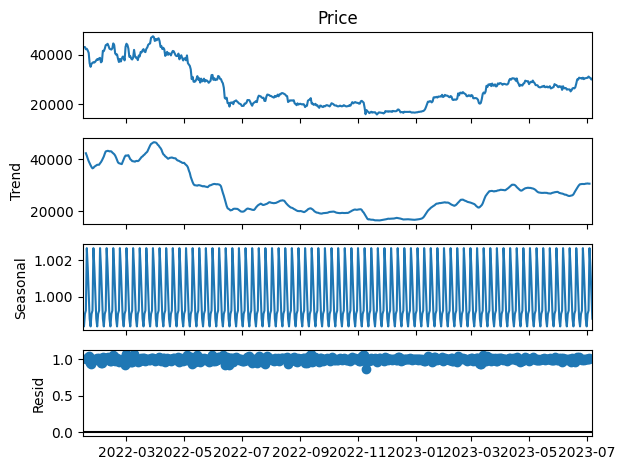

In [ ]:
import statsmodels.api as sm

sd_result = sm.tsa.seasonal_decompose(df.Price, model='multiplicative')

sd_result.plot()
plt.show()

In [ ]:
sd_result.seasonal[:10]

Date
2022-01-14    0.998801
2022-01-15    0.998381
2022-01-16    0.999064
2022-01-17    0.999248
2022-01-18    1.002656
2022-01-19    1.001586
2022-01-20    1.000263
2022-01-21    0.998801
2022-01-22    0.998381
2022-01-23    0.999064
Name: seasonal, dtype: float64

В результате мы можем заметить четкую сезонность равную 7 дням

In [ ]:
seasonal_period = 7

## Генерация признаков

In [ ]:
!pip install tsfresh -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

def preprocess_data_tsfresh(data_df, lag_start=7, lag_end=20, test_size=0.15):
  data = data_df.copy()

  test_index = int(len(data) * test_size)

  # Добавление лагов
  for i in range(lag_start, lag_end):
    data[f"lag_{i}"] = data.Price.shift(i)


  data["week"] = data.index.week
  data["month"] = data.index.month
  data["year"] = data.index.year

  # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
  data["week_average"] = list(map(code_mean(data[:-test_index], "week", "Open").get, data.week))
  data["month_average"] = list(map(code_mean(data[:-test_index], "month", "Open").get, data.month))
  data["year_average"] = list(map(code_mean(data[:-test_index], "year", "Open").get, data.year))
  # выкидываем закодированные средними признаки
  data.drop(["week", 'month', 'year'], axis=1, inplace=True)
  data.dropna(inplace=True)

  agg_df = data.copy()

  data['Date'] = data.index
  data.reset_index(drop=True, inplace=True)

  # Генерация признаков для прогнозирования временных рядов при помощи библиотеки TsFresh
  settings_efficient = settings.ComprehensiveFCParameters()
  X = extract_features(data[['Price', 'Date']], column_id='Date', impute_function=impute, default_fc_parameters=settings_efficient)

  X["week_average"] = agg_df["week_average"]
  X["month_average"] = agg_df["month_average"]
  X["year_average"] = agg_df["year_average"]

  for i in range(lag_start, lag_end):
    X[f"lag_{i}"] = agg_df[f"lag_{i}"]

  X_train = X[:-test_index]
  y_train = data.Price[:-test_index]
  X_test = X[-test_index:]
  y_test = data.Price[-test_index:]


  return X_train, X_test, y_train, y_test

In [ ]:
def preprocess_data(data_df, lag_start=7, lag_end=20, test_size=0.15):
  data = data_df.copy()

  test_index = int(len(data) * test_size)

  # Добавление лагов
  for i in range(lag_start, lag_end):
    data[f"lag_{i}"] = data.Price.shift(i)


  data["week"] = data.index.week
  data["month"] = data.index.month
  data["year"] = data.index.year

  # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
  data["week_average"] = list(map(code_mean(data[:-test_index], "week", "Open").get, data.week))
  data["month_average"] = list(map(code_mean(data[:-test_index], "month", "Open").get, data.month))
  data["year_average"] = list(map(code_mean(data[:-test_index], "year", "Open").get, data.year))
  # выкидываем закодированные средними признаки
  data.drop(["week", 'month', 'year'], axis=1, inplace=True)
  data.dropna(inplace=True)

  X_train = data[:-test_index].drop(columns=['Price'])
  y_train = data.Price[:-test_index]
  X_test = data[-test_index:].drop(columns=['Price'])
  y_test = data.Price[-test_index:]


  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df)

X_train.head()

,Open,High,Low,Vol.,Change,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,week_average,month_average,year_average
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,38711.2,38853.8,36682.3,53740.0,-0.0470,36800.4,36950.6,36686.3,36269.5,35075.2,...,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,43073.3,31134.521429,31932.253571,27681.882955
2022-02-03,36890.2,37304.3,36297.3,50350.0,0.0108,37164.3,36800.4,36950.6,36686.3,36269.5,...,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,31134.521429,31932.253571,27681.882955
2022-02-04,37287.8,41689.0,37041.1,95490.0,0.1148,37745.1,37164.3,36800.4,36950.6,36686.3,...,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,31134.521429,31932.253571,27681.882955
2022-02-05,41566.5,41899.8,40963.3,46320.0,-0.0037,38170.8,37745.1,37164.3,36800.4,36950.6,...,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,31134.521429,31932.253571,27681.882955
2022-02-06,41411.9,42614.8,41176.3,31200.0,0.0237,37917.7,38170.8,37745.1,37164.3,36800.4,...,36686.3,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,31134.521429,31932.253571,27681.882955


# Модель Хольта-Винтерса

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df_y = y_train.copy()
train_df_y.index = X_train.index
test_df_y = y_test.copy()
test_df_y.index = X_test.index

train_df_y

Date
2022-02-02    36890.2
2022-02-03    37287.8
2022-02-04    41567.6
2022-02-05    41412.1
2022-02-06    42392.2
               ...   
2023-04-13    30387.4
2023-04-14    30472.5
2023-04-15    30299.6
2023-04-16    30310.3
2023-04-17    29434.9
Name: Price, Length: 440, dtype: float64

In [ ]:
fit1 = ExponentialSmoothing(
    train_df_y,
    trend='add',
    seasonal='mul',
    use_boxcox=True,
    damped_trend=True,
    initialization_method='legacy-heuristic'
).fit()
fcast1 = fit1.forecast(len(test_df_y)).rename("H-W with add trend and mult seasonal and damped trend")
fcast1

2023-04-18    29427.507443
2023-04-19    29139.693628
2023-04-20    28913.915534
2023-04-21    28859.033642
2023-04-22    28924.778912
                  ...     
2023-07-03    29725.290106
2023-07-04    29564.624804
2023-07-05    29272.591173
2023-07-06    29043.293156
2023-07-07    28986.588611
Freq: D, Name: H-W with add trend and mult seasonal and damped trend, Length: 81, dtype: float64

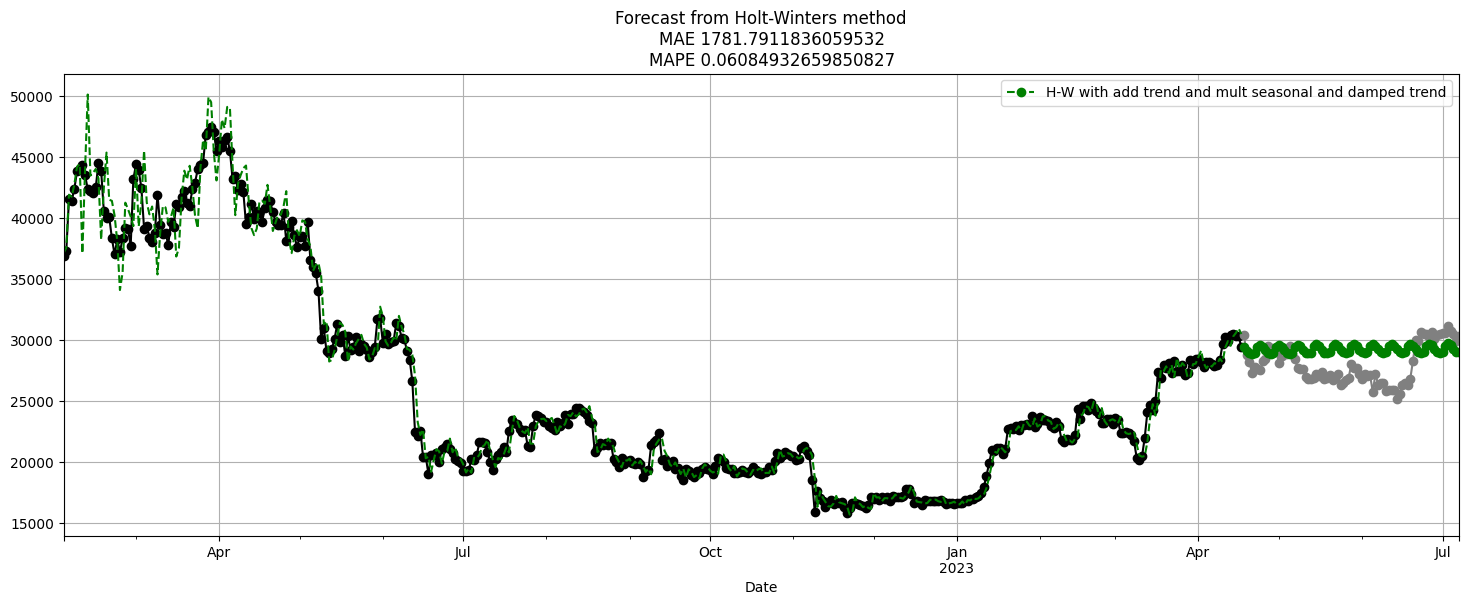

In [ ]:
mae_fcast1 = mean_absolute_error(fcast1, test_df_y)
mape_fcast1 = mean_absolute_percentage_error(fcast1, test_df_y)

ax = train_df_y.plot(
    figsize=(18, 6),
    marker="o",
    color='black',
    title=f'''Forecast from Holt-Winters method
    MAE {mae_fcast1}
    MAPE {mape_fcast1}''',
)

test_df_y.plot(ax=ax, marker='o', color='grey', label='Test quantity')
fit1.fittedvalues.plot(ax=ax, style='--', color='g')
fcast1.plot(ax=ax, style='--', marker='o', color='g', legend=True)
plt.grid(True)
plt.show()

# SARIMAX

In [ ]:
sarimax = sm.tsa.SARIMAX(
    train_df_y,
    order=(6, 2, 1),
    seasonal_order=(6, 1, 1, seasonal_period),
    exog=X_train
)

results_sarimax = sarimax.fit()

In [ ]:
predictions_sarimax = results_sarimax.get_forecast(steps=len(test_df_y), exog=X_test)
# predictions_sarimax = results_sarimax.get_forecast(steps=len(test_df_y))

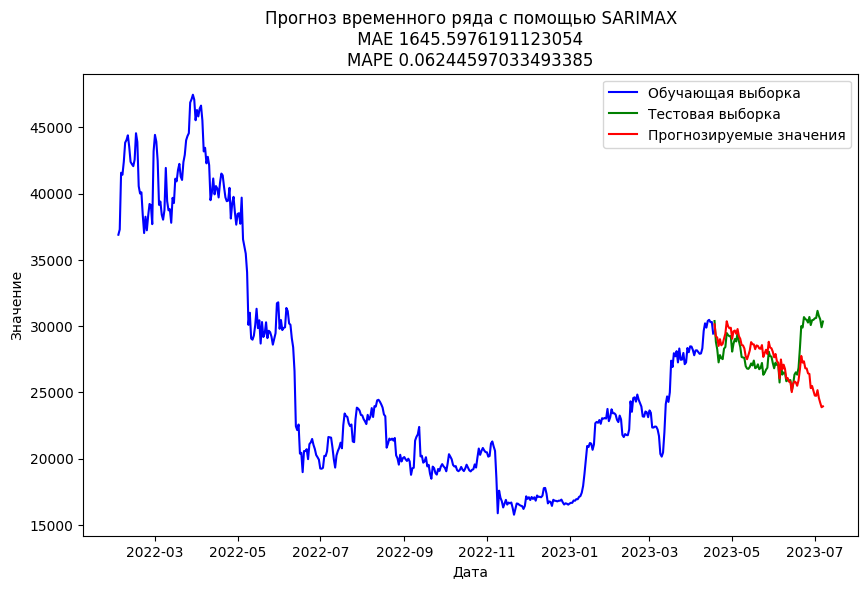

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_df_y.index, train_df_y, label='Обучающая выборка', color='blue')
plt.plot(test_df_y.index, test_df_y, label='Тестовая выборка', color='green')
plt.plot(test_df_y.index, predictions_sarimax.predicted_mean, label='Прогнозируемые значения', color='red')
#plt.fill_between(test_df_y.index, predictions_sarimax.conf_int().iloc[:, 0], predictions_sarimax.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title(f'''Прогноз временного ряда с помощью SARIMAX\n MAE {mean_absolute_error(predictions_sarimax.predicted_mean, test_df_y)}
MAPE {mean_absolute_percentage_error(predictions_sarimax.predicted_mean, test_df_y)}''')
plt.show()

# Random Forest Regression



In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=5, n_estimators=500)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

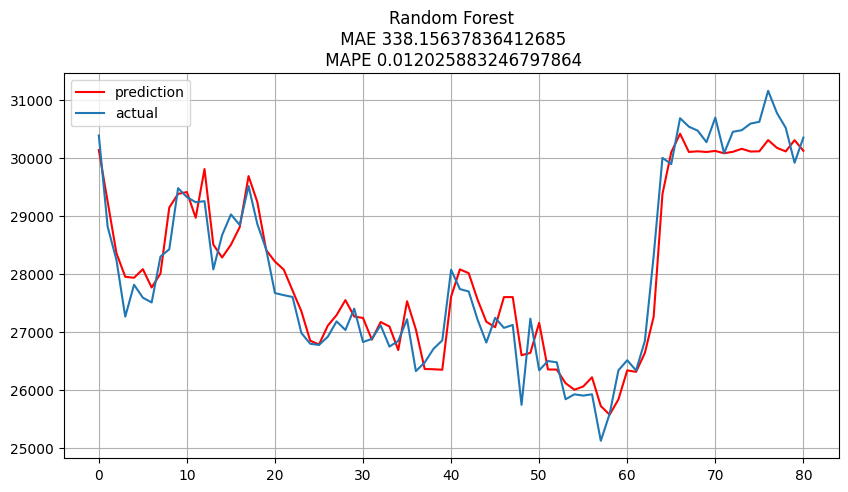

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest\n MAE {mean_absolute_error(preds, y_test)}\n MAPE {mean_absolute_percentage_error(preds, y_test)}");

## Кросс-валидация

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor()

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

param_grid = {
    'max_depth': np.arange(20, 26, 3),
    'n_estimators': np.arange(1000, 2001, 250),
}

search = GridSearchCV(rf, param_grid, n_jobs=-1, cv=tscv, refit=True, scoring='neg_mean_absolute_error')

search.fit(X, y)

print(search.best_params_)

{'max_depth': 20, 'n_estimators': 1500}


## Обучение и оценка модели с лучшими параметрами

In [ ]:
rf = RandomForestRegressor(max_depth=20, n_estimators=1500)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

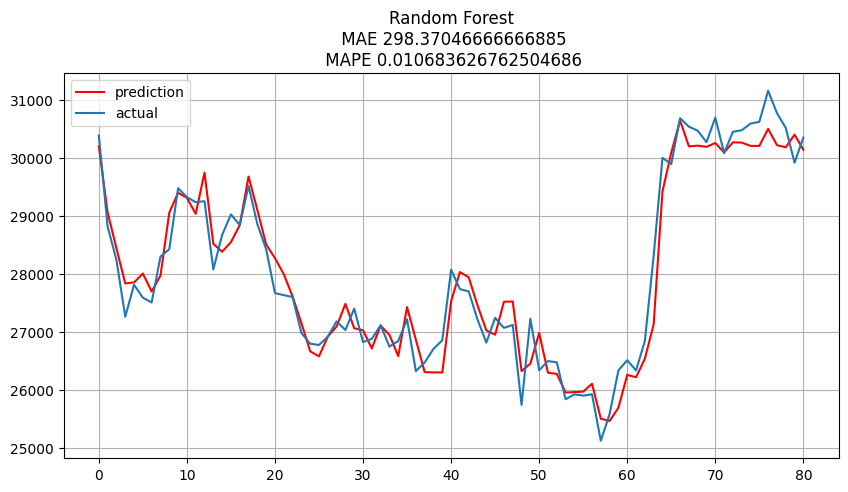

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest\n MAE {mean_absolute_error(preds, y_test)}\n MAPE {mean_absolute_percentage_error(preds, y_test)}");